In [5]:
import sys
sys.path.append('..')

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.eda.plot_distribution import plot_distribution

In [7]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Load data

In [4]:
train = pd.read_excel('../dataset/train.xlsx', sheet_name= 'adult_train')

In [8]:
train.head(3)

,id,age,sector,edu,marital_status,field,family_rel,gender,investment_gain,investment_loss,working_hours,high_income
0,1,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,no
1,2,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,no
2,3,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,no


# EDA

In [7]:
train.isnull().sum()

id                 0
age                0
sector             0
edu                0
marital_status     0
field              0
family_rel         0
gender             0
investment_gain    0
investment_loss    0
working_hours      0
high_income        0
dtype: int64

In [9]:
# Check for duplicates
duplicates = train[train.duplicated()]

if not duplicates.empty:
    print("Duplicate rows found:")
    print(duplicates)
else:
    print("No duplicate rows found.")

No duplicate rows found.


### Age & Income

In [10]:
train['age'].min(), train['age'].max()

bins = [0, 20, 30, 40, 50, 60, 90]
labels = ['<20 yo', '20-30 yo', '30-40 yo', '40-50 yo', '50-60 yo', '>60 yo']

train['age_group'] = pd.cut(train['age'], labels = labels, bins= bins)
train['age_group'].value_counts()

age_group
30-40 yo    8546
20-30 yo    8162
40-50 yo    6983
50-60 yo    4128
<20 yo      2410
>60 yo      2332
Name: count, dtype: int64

In [12]:
# Encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

train['high_income'] = le.fit_transform(train['high_income'])

tmp = train.groupby(['age_group']).agg({'high_income': ['sum', 'count']}).reset_index()
tmp['pct'] = tmp['high_income']['sum'] / tmp['high_income']['count'] * 100
tmp

/var/folders/jl/ncw1ybbj0fs6f3mcht1ks56h0000gn/T/ipykernel_16703/3886031423.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = train.groupby(['age_group']).agg({'high_income': ['sum', 'count']}).reset_index()


age_group high_income              pct
                    sum count           
0    <20 yo           2  2410   0.082988
1  20-30 yo         680  8162   8.331291
2  30-40 yo        2406  8546  28.153522
3  40-50 yo        2655  6983  38.020908
4  50-60 yo        1547  4128  37.475775
5    >60 yo         551  2332  23.627787

Người trong độ tuổi `40-50`, `50-60` có tỷ lệ người **thu nhập cao cao nhất** và nhóm tuổi `30-40` đạt tỷ lệ cao ngay sau 2 nhóm tuổi trên với **28%** là người có thu nhập cao. 3 nhóm tuổi này là nhóm tuổi có nhiều kinh nghiệm, thường có các vị trí cao trong công việc. Nhóm tuổi `> 60` cũng có tỷ lệ tương đối cao.

Tuy nhiên, nhóm tuổi từ `20-30` lại có tỷ lệ thu nhập cao thấp một cách bất ngờ. Chỉ **8%** người trong độ tuổi này có thu nhập cao mặc dù đây là nhóm lao động trẻ. 

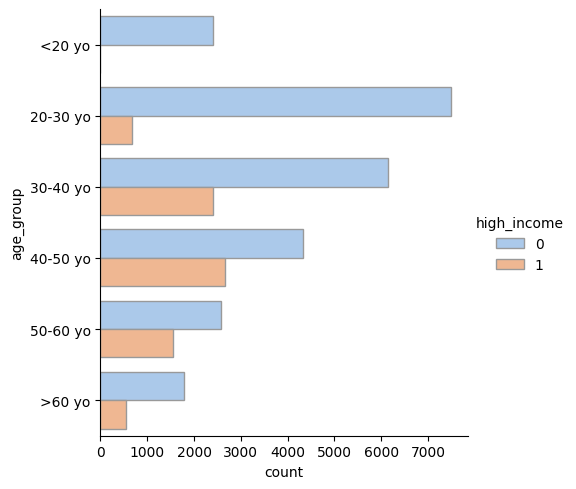

In [13]:
sns.catplot(
    data=train, y="age_group", hue="high_income", kind="count",
    palette="pastel", edgecolor=".6",
)

/var/folders/jl/ncw1ybbj0fs6f3mcht1ks56h0000gn/T/ipykernel_16703/684842607.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  high_ic_count = high_income_df.groupby('age_group')['high_income'].size().reset_index()


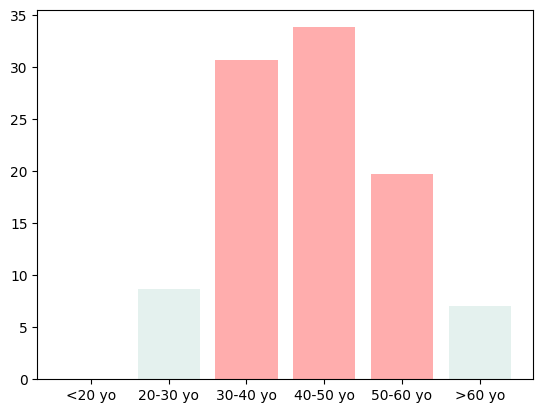

In [14]:
high_income_df = train[train['high_income'] == 1]
high_ic_count = high_income_df.groupby('age_group')['high_income'].size().reset_index()
high_ic_total = high_income_df.shape[0]
high_ic_count['pct'] = high_ic_count['high_income'] / high_ic_total * 100 

top_3 = high_ic_count['pct'].nlargest(3)

# Generate colors based on the condition
colors = ['#FFADAD' if pct in top_3.values else '#E4F1EE' for pct in high_ic_count['pct']]

plt.bar(high_ic_count.age_group, high_ic_count['pct'].values, color = colors)
plt.show()

3 nhóm tuổi 30-40, 40-50 và 50-60 vẫn là 3 nhóm có tỷ lệ thu nhập cao dẫn đầu

## sector

In [19]:
# tỷ lệ trong từng nhóm

def rate_each_group(train, feat):
    tmp = train.groupby([feat]).agg({'high_income': ['sum', 'count']}).reset_index()
    tmp['pct'] = tmp['high_income']['sum'] / tmp['high_income']['count'] * 100
    
    # plot
    sns.catplot(
    data=train, y=feat, 
                hue="high_income", kind="count",
                palette="pastel", edgecolor=".6",
    )
    return tmp

sector high_income               pct
                             sum  count           
0                  ?         191   1836  10.403050
1        Federal-gov         371    960  38.645833
2          Local-gov         617   2093  29.479216
3       Never-worked           0      7   0.000000
4            Private        4963  22696  21.867289
5       Self-emp-inc         622   1116  55.734767
6   Self-emp-not-inc         724   2541  28.492719
7          State-gov         353   1298  27.195686
8        Without-pay           0     14   0.000000

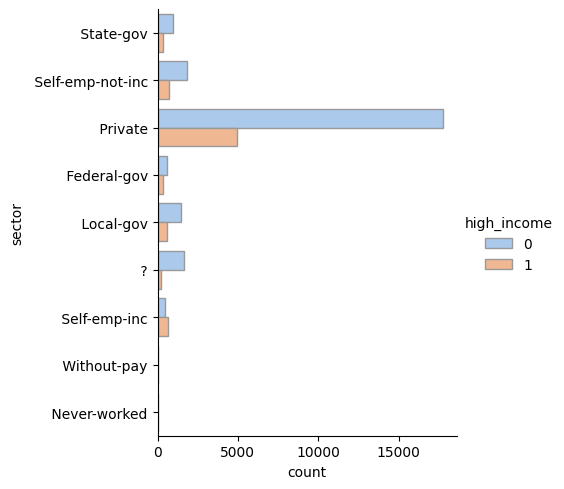

In [20]:
rate_each_group(train, 'sector')

In [21]:
# tỷ lệ giữa các nhóm

def rate_among_groups(high_income_df, feat):
    high_ic_count = high_income_df.groupby(feat)['high_income'].size().reset_index()
    high_ic_total = high_income_df.shape[0]
    high_ic_count['pct'] = high_ic_count['high_income'] / high_ic_total * 100 

    top_3 = high_ic_count['pct'].nlargest(3)

    # Generate colors based on the condition
    colors = ['#FFADAD' if pct in top_3.values else '#E4F1EE' for pct in high_ic_count['pct']]
    plt.xticks(rotation= 90)
    plt.bar(high_ic_count[feat], high_ic_count['pct'].values, color = colors)
    plt.show()
    
    return high_ic_count

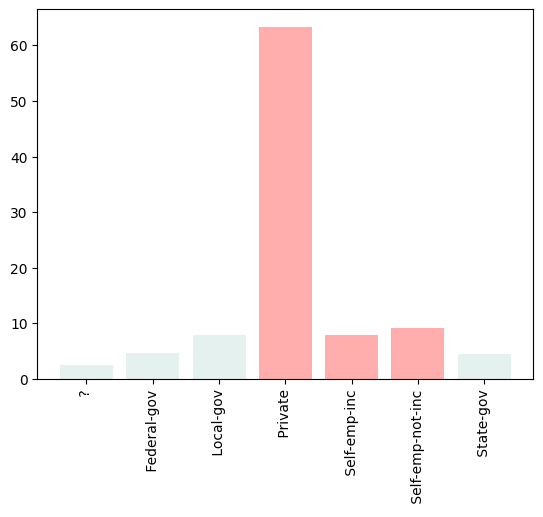

,sector,high_income,pct
0,?,191,2.435914
1,Federal-gov,371,4.731539
2,Local-gov,617,7.868894
3,Private,4963,63.295498
4,Self-emp-inc,622,7.932662
5,Self-emp-not-inc,724,9.233516
6,State-gov,353,4.501977


In [22]:
rate_among_groups(high_income_df, 'sector')

## edu

edu high_income               pct
                          sum  count           
0            10th          62    933   6.645230
1            11th          60   1175   5.106383
2            12th          33    433   7.621247
3         1st-4th           6    168   3.571429
4         5th-6th          16    333   4.804805
5         7th-8th          40    646   6.191950
6             9th          27    514   5.252918
7      Assoc-acdm         265   1067  24.835989
8       Assoc-voc         361   1382  26.121563
9       Bachelors        2221   5355  41.475257
10      Doctorate         306    413  74.092010
11        HS-grad        1675  10501  15.950862
12        Masters         959   1723  55.658735
13      Preschool           0     51   0.000000
14    Prof-school         423    576  73.437500
15   Some-college        1387   7291  19.023454

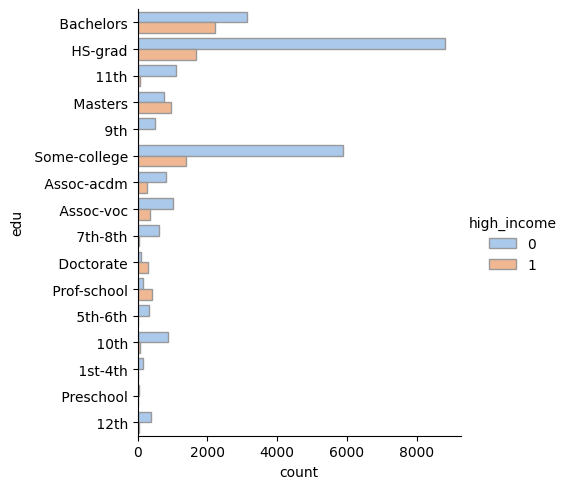

In [23]:
rate_each_group(train, 'edu')

Trong các nhóm Prof-school, Doctorate, tỷ lệ người có thu nhập cao chiếm hơn 70%. Bên cạnh đó, nhóm Masters cũng là nhóm trình độ giáo dục có tỷ lệ người đạt thu nhập cao trên 50%. Số lượng người có trình độ giáo dục thuộc 3 nhóm này ít nhưng vì số người có thu nhập cao lớn hơn nên tỷ lệ rất lớn. Đây cũng là 3 nhóm trình độ giáo dục cao => Dẫn đến thu nhập cao. 

Nhóm Bachelors là nhóm trình độ giáo dục tương đối phổ biến hơn 3 nhóm trên => Số người có thu nhập cao lớn hơn nhưng ngược lại số người không có thu nhập cao nhiều nên tỷ lệ thấp hơn 3 nhóm trên

HS-grad (tốt nghiệp cấp 3) là nhóm có số lượng người cao nhất trong dataset này. Mặc dù số lượng người thu nhập cao chỉ đứng sau nhóm Masters, tuy nhiên số lượng người không có thu nhập cao quá nhiều => tỷ lệ người có thu nhập cao thấp, chỉ có 15%

Các nhóm trình độ giáo dục từ lớp 12 trở xuống nhìn chung chỉ có tỷ lệ thu nhập cao dưới 10%. Trong đó preschool có tỷ lệ 0%. Đây là nhóm trình độ giáo dục chưa đủ khả năng để tham gia thị trường lao động thật sự nên thu nhập có thể chỉ đến từ các nguồn nhỏ lẻ như làm part-time,...

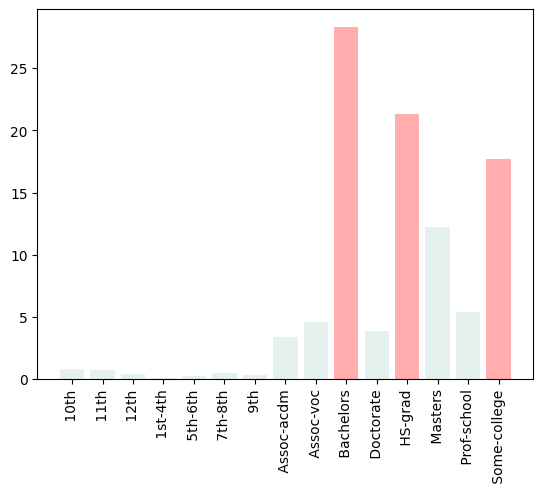

,edu,high_income,pct
0,10th,62,0.790715
1,11th,60,0.765209
2,12th,33,0.420865
3,1st-4th,6,0.076521
4,5th-6th,16,0.204056
5,7th-8th,40,0.510139
6,9th,27,0.344344
7,Assoc-acdm,265,3.379671
8,Assoc-voc,361,4.604005
9,Bachelors,2221,28.325469


In [24]:
rate_among_groups(high_income_df, 'edu')

Kết quả giữa các nhóm cho thấy Bachelors, HS-grad, Some-college là 3 nhóm có tỷ lệ thu nhập cao cao nhất do số lượng người trong 3 nhóm này nhiều, cùng với trình độ giáo dục tại 3 nhóm này nằm ở mức trung bình. 

**Càng có trình độ giáo dục cao càng có thu nhập cao**

## marital_status

marital_status high_income               pct
                                  sum  count           
0                Divorced         463   4443  10.420887
1       Married-AF-spouse          10     23  43.478261
2      Married-civ-spouse        6692  14976  44.684829
3   Married-spouse-absent          34    418   8.133971
4           Never-married         491  10683   4.596087
5               Separated          66   1025   6.439024
6                 Widowed          85    993   8.559919

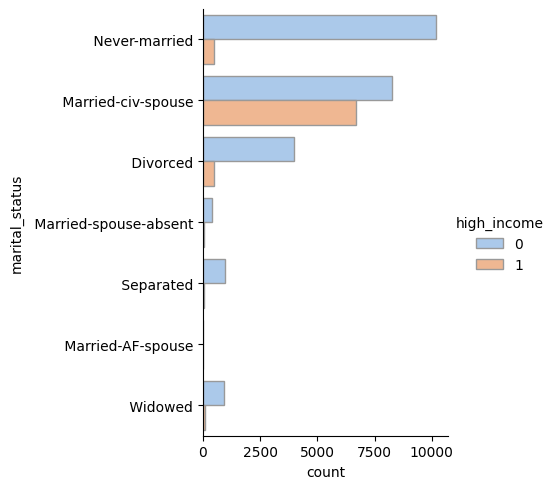

In [25]:
rate_each_group(train, 'marital_status')

Nhóm Married-AF-spouse, Married-civ-spouse là 2 nhóm có tỷ lệ người có thu nhập cao cao nhất. 

Nhóm Never-married là nhóm tình trạng có tỷ lệ người thu nhập cao thấp nhất (chỉ khoảng 4%). Số lượng người thu nhập cao trong nhóm này rất ít so với số không có thu nhập cao.

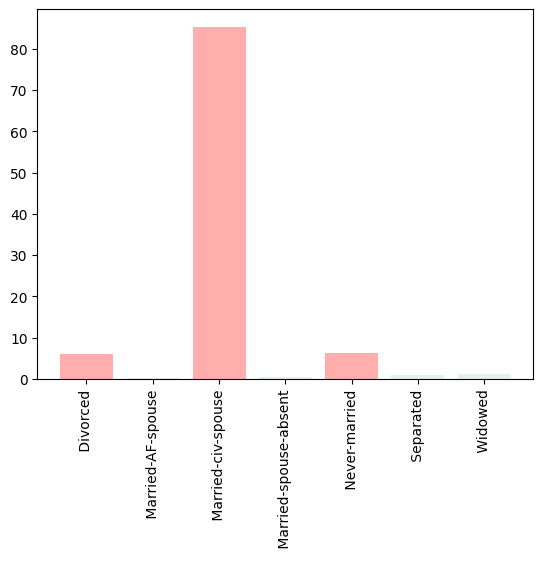

,marital_status,high_income,pct
0,Divorced,463,5.904859
1,Married-AF-spouse,10,0.127535
2,Married-civ-spouse,6692,85.346257
3,Married-spouse-absent,34,0.433618
4,Never-married,491,6.261956
5,Separated,66,0.841729
6,Widowed,85,1.084045


In [26]:
rate_among_groups(high_income_df, 'marital_status')

Chủ yếu người có thu nhập cao đến từ nhóm Married-civ-spouse do số lượng người có thu nhập cao ở nhóm này lớn nhất, và tỷ lệ người có thu nhập cao trong nhóm tình trạng này cũng cao nhất

## field

field high_income              pct
                               sum count           
0                    ?         191  1843  10.363538
1         Adm-clerical         507  3770  13.448276
2         Armed-Forces           1     9  11.111111
3         Craft-repair         929  4099  22.664064
4      Exec-managerial        1968  4066  48.401377
5      Farming-fishing         115   994  11.569416
6    Handlers-cleaners          86  1370   6.277372
7    Machine-op-inspct         250  2002  12.487512
8        Other-service         137  3295   4.157815
9      Priv-house-serv           1   149   0.671141
10      Prof-specialty        1859  4140  44.903382
11     Protective-serv         211   649  32.511556
12               Sales         983  3650  26.931507
13        Tech-support         283   928  30.495690
14    Transport-moving         320  1597  20.037570

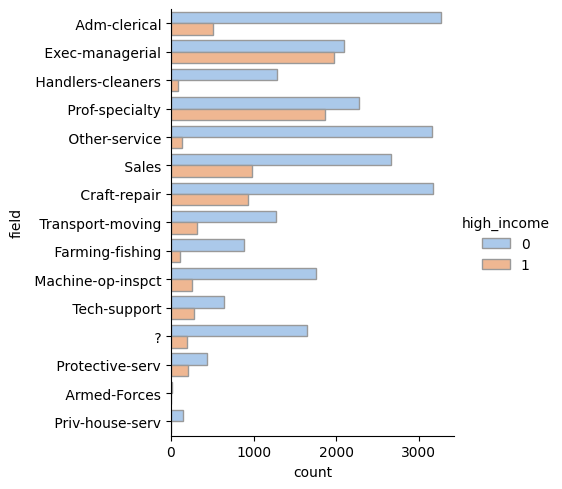

In [27]:
rate_each_group(train, 'field')

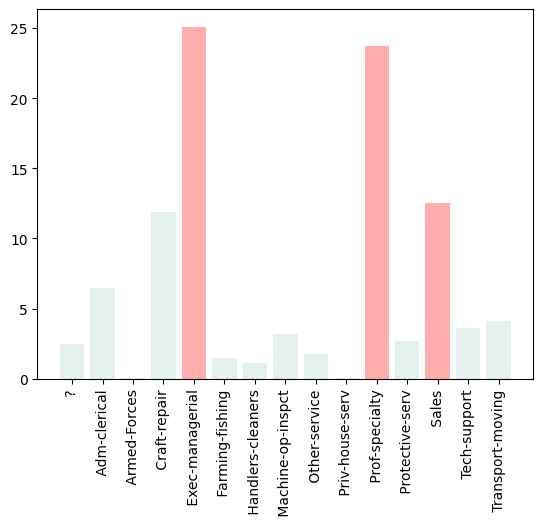

,field,high_income,pct
0,?,191,2.435914
1,Adm-clerical,507,6.466012
2,Armed-Forces,1,0.012753
3,Craft-repair,929,11.847979
4,Exec-managerial,1968,25.098839
5,Farming-fishing,115,1.466650
6,Handlers-cleaners,86,1.096799
7,Machine-op-inspct,250,3.188369
8,Other-service,137,1.747226
9,Priv-house-serv,1,0.012753


In [28]:
rate_among_groups(high_income_df, 'field')

## family_rel

family_rel high_income               pct
                           sum  count           
0          Husband        5918  13193  44.857121
1    Not-in-family         856   8305  10.307044
2   Other-relative          37    981   3.771662
3        Own-child          67   5068   1.322021
4        Unmarried         218   3446   6.326175
5             Wife         745   1568  47.512755

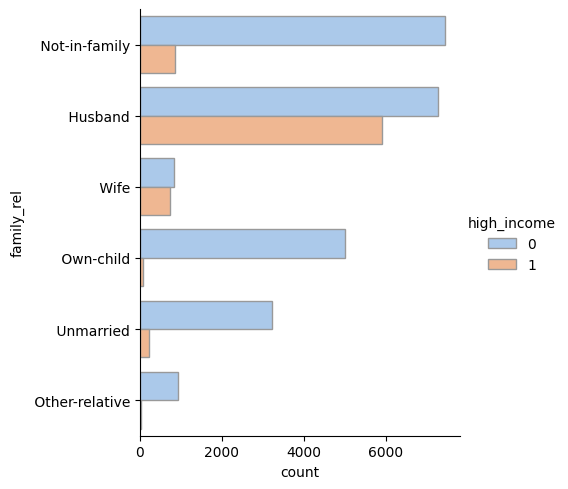

In [29]:
rate_each_group(train, 'family_rel')

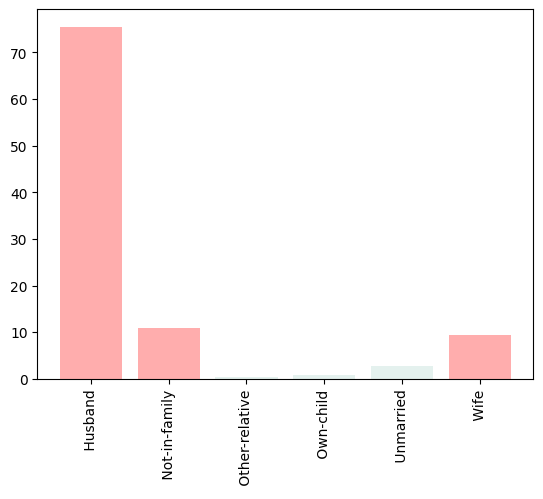

,family_rel,high_income,pct
0,Husband,5918,75.475067
1,Not-in-family,856,10.916975
2,Other-relative,37,0.471879
3,Own-child,67,0.854483
4,Unmarried,218,2.780258
5,Wife,745,9.501339


In [30]:
rate_among_groups(high_income_df, 'family_rel')

## gender

gender high_income               pct
                   sum  count           
0   Female        1179  10771  10.946059
1     Male        6662  21790  30.573658

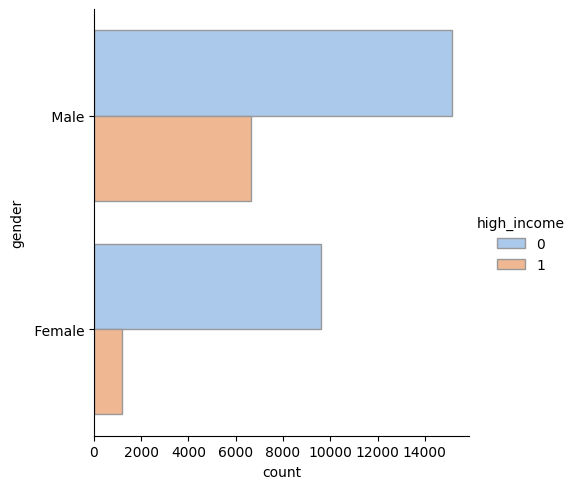

In [31]:
rate_each_group(train, 'gender')

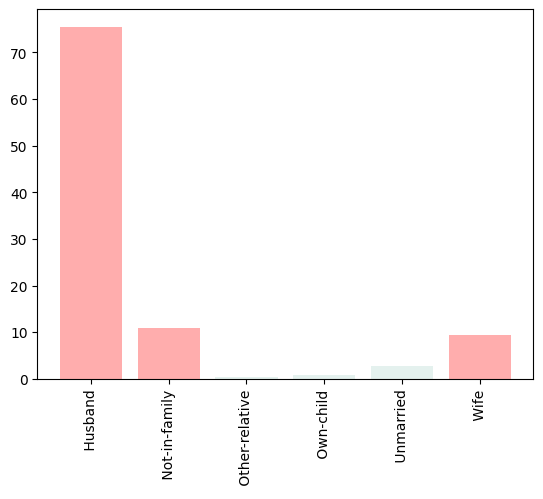

,family_rel,high_income,pct
0,Husband,5918,75.475067
1,Not-in-family,856,10.916975
2,Other-relative,37,0.471879
3,Own-child,67,0.854483
4,Unmarried,218,2.780258
5,Wife,745,9.501339


In [32]:
rate_among_groups(high_income_df, 'family_rel')

# Numercial columns

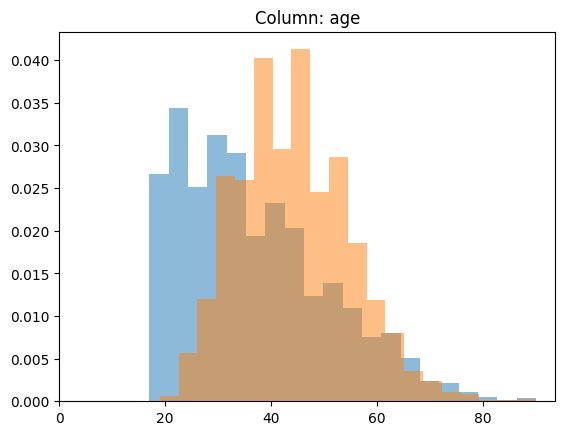

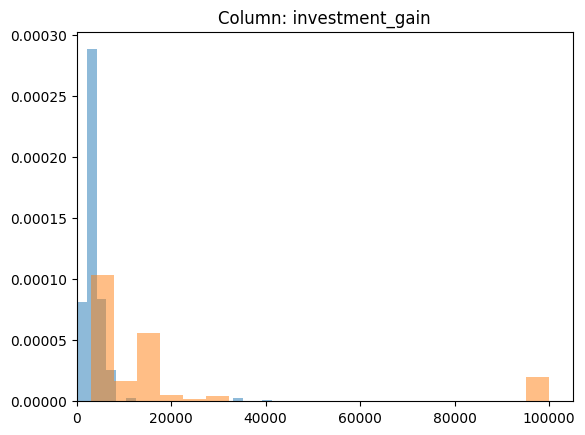

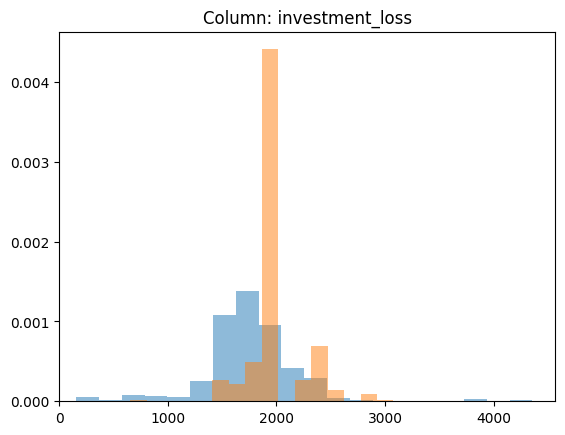

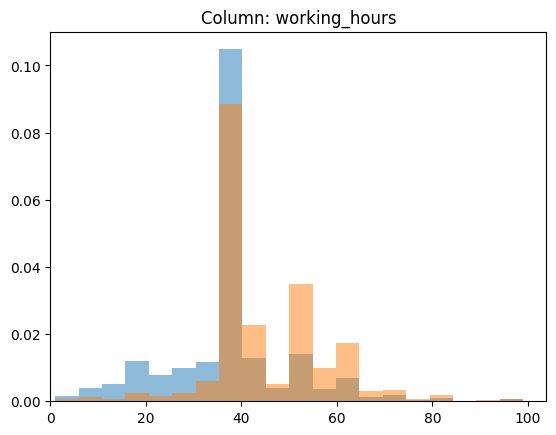

In [39]:
num_cols = ['age', 'investment_gain', 'investment_loss', 'working_hours']

for colname in num_cols:
    df = train
    
    if colname in ('investment_gain', 'investment_loss'):
        # avoid this issue we cut zero values
        df = df[(train[colname] != 0) & ~train[colname].isnull()]
        
    low_income = df.loc[df['high_income'] == 0, colname]
    high_income = df.loc[df['high_income'] == 1, colname]
    
    plt.title('Column: ' + colname)
    plt.hist(low_income, label= 0, bins=20, density=True, alpha=0.5)
    plt.hist(high_income, label=1, bins=20, density=True, alpha=0.5)
    
    xmin, xmax = plt.xlim()
    plt.xlim(0, xmax)
    plt.show()

## investment behavior

In [49]:
# Agangle_spectrume vs Investment_gain

tmp = train.groupby('age_group')['investment_gain'].mean().sort_values(ascending = False)
tmp

/tmp/ipykernel_33/4050219997.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = train.groupby('age_group')['investment_gain'].mean().sort_values(ascending = False)


age_group
50-60 yo    1753.673450
>60 yo      1740.178816
40-50 yo    1674.111986
30-40 yo    1028.831032
20-30 yo     377.601201
<20 yo        94.343568
Name: investment_gain, dtype: float64

<BarContainer object of 6 artists>

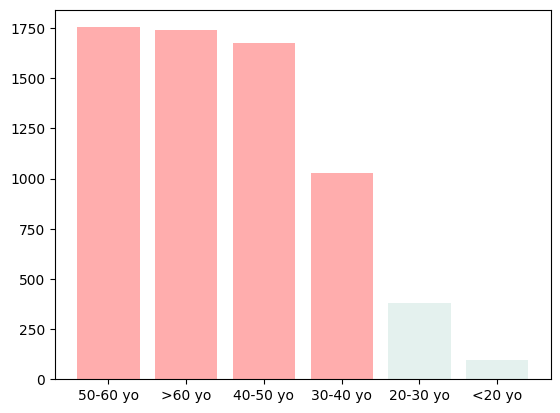

In [53]:
colors = ['#E4F1EE' if i > 3 else '#FFADAD' for i in range(len(tmp))]
plt.bar(tmp.index, tmp.values, color= colors)

Càng ở nhóm lớn tuổi càng có trung bình investment gain lớn. Đặc biệt, nhóm tuổi từ 50-60 có investment cao nhất.

In [65]:
def investment_behavior(feat, investment):
    tmp = train.groupby(feat)[investment].mean().sort_values(ascending = False)
    colors = ['#E4F1EE' if i > 3 else '#FFADAD' for i in range(len(tmp))]
    
    plt.bar(tmp.index, tmp.values, color= colors)
    plt.xticks(rotation= 90)
    plt.show()
    return tmp

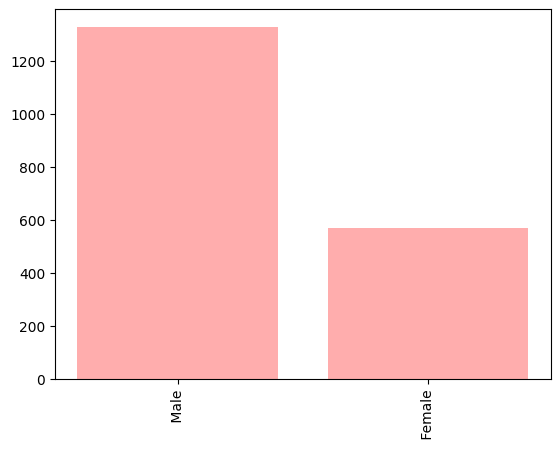

gender
Male      1329.370078
Female     568.410547
Name: investment_gain, dtype: float64

In [66]:
investment_behavior('gender', 'investment_gain')

Trung bình gain của male sẽ cao hơn female

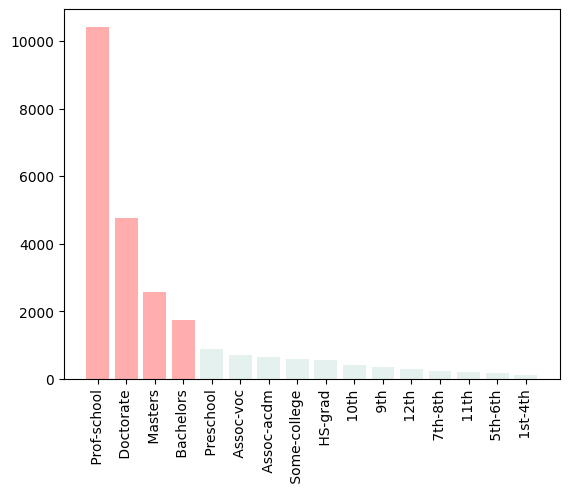

edu
Prof-school     10414.416667
Doctorate        4770.145278
Masters          2562.563552
Bachelors        1756.299533
Preschool         898.392157
Assoc-voc         715.051375
Assoc-acdm        640.399250
Some-college      598.824167
HS-grad           576.800114
10th              404.574491
9th               342.089494
12th              284.087760
7th-8th           233.939628
11th              215.097872
5th-6th           176.021021
1st-4th           125.875000
Name: investment_gain, dtype: float64

In [68]:
investment_behavior('edu', 'investment_gain')

Trình độ học vấn càng cao thì trung bình investment sẽ càng cao

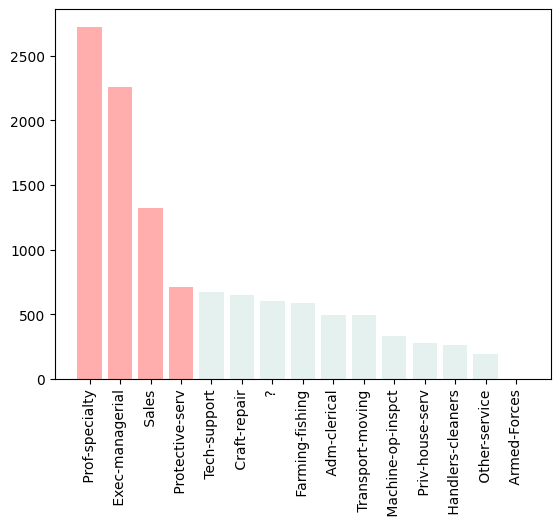

field
Prof-specialty       2726.699517
Exec-managerial      2262.772996
Sales                1319.829315
Protective-serv       708.098613
Tech-support          673.552802
Craft-repair          649.512808
?                     604.491047
Farming-fishing       589.726358
Adm-clerical          495.954907
Transport-moving      490.323732
Machine-op-inspct     328.689311
Priv-house-serv       279.852349
Handlers-cleaners     257.572993
Other-service         191.301669
Armed-Forces            0.000000
Name: investment_gain, dtype: float64

In [69]:
investment_behavior('field', 'investment_gain')

Những nghề chuyên gia, quản lý là những nhóm nghề cấp cao, có trung bình investment gain cao nhất

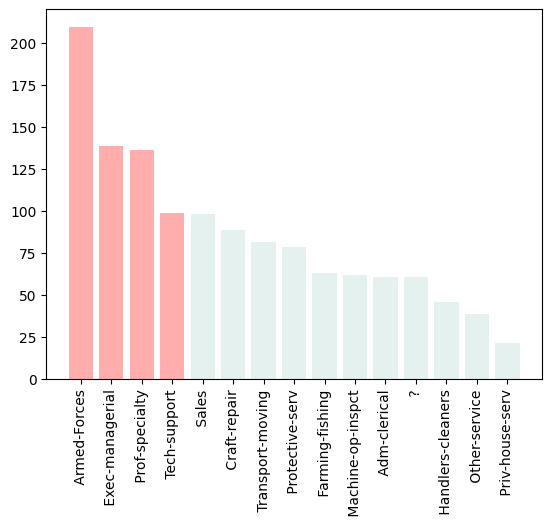

field
Armed-Forces         209.666667
Exec-managerial      138.838416
Prof-specialty       136.139372
Tech-support          98.665948
Sales                 98.300548
Craft-repair          88.465235
Transport-moving      81.480902
Protective-serv       78.334361
Farming-fishing       63.075453
Machine-op-inspct     61.706294
Adm-clerical          60.794430
?                     60.529571
Handlers-cleaners     45.635766
Other-service         38.250683
Priv-house-serv       21.449664
Name: investment_loss, dtype: float64

In [70]:
investment_behavior('field', 'investment_loss')

Tuy nhiên, những nhóm nghề quản lý và chuyên gia cũng là những nhóm nghề thực hiện investment nhiều nên trung bình loss cũng cao hơn so với các nhóm ngành khác. 

## Field having most working hours.

In [75]:
train.groupby('field').agg({'working_hours': ['min', 'mean', 'max']}).reset_index()

field working_hours               
                                 min       mean max
0                    ?             1  31.906131  99
1         Adm-clerical             1  37.558355  80
2         Armed-Forces             8  40.666667  60
3         Craft-repair             1  42.304221  99
4      Exec-managerial             1  44.987703  99
5      Farming-fishing             2  46.989940  99
6    Handlers-cleaners             2  37.947445  95
7    Machine-op-inspct             1  40.755744  96
8        Other-service             1  34.701669  99
9      Priv-house-serv             4  32.885906  99
10      Prof-specialty             1  42.386715  99
11     Protective-serv             3  42.870570  99
12               Sales             2  40.781096  99
13        Tech-support             3  39.432112  99
14    Transport-moving             5  44.656230  99

Nhóm quản lý là nhóm nghề có giờ làm việc trong tuần cao đồng đều nhất (cả số giờ tối thiểu, trung bình số giờ và số giờ tối đa). Theo sau là nhóm nghề farming-fishing, transport-moving,... 

## Level of education relative to hours worked

In [76]:
train.groupby('edu').agg({'working_hours': ['min', 'mean', 'max']}).reset_index()

edu working_hours               
                            min       mean max
0            10th             1  37.052519  99
1            11th             2  33.925957  99
2            12th             6  35.780600  99
3         1st-4th             4  38.255952  96
4         5th-6th             3  38.897898  84
5         7th-8th             2  39.366873  99
6             9th             1  38.044747  99
7      Assoc-acdm             1  40.504217  99
8       Assoc-voc             1  41.610709  99
9       Bachelors             2  42.614006  99
10      Doctorate             1  46.973366  99
11        HS-grad             1  40.575374  99
12        Masters             1  43.836332  99
13      Preschool            10  36.647059  75
14    Prof-school             2  47.425347  99
15   Some-college             1  38.852284  99

Trình độ giáo dục càng cao (Prof-school, Doctorate, Masters) càng có số giờ làm cao. Tuy nhiên, nhóm trình độ pre-school và 12th lại có số giờ tối thiểu cao nhất.

## Gender - Field vs Income

In [83]:
train.groupby(['gender', 'field'])['high_income'].sum()

gender  field            
Female  ?                      52
        Adm-clerical          212
        Craft-repair           20
        Exec-managerial       280
        Farming-fishing         2
        Handlers-cleaners       4
        Machine-op-inspct      20
        Other-service          51
        Priv-house-serv         1
        Prof-specialty        385
        Protective-serv        10
        Sales                  88
        Tech-support           45
        Transport-moving        9
Male    ?                     139
        Adm-clerical          295
        Armed-Forces            1
        Craft-repair          909
        Exec-managerial      1688
        Farming-fishing       113
        Handlers-cleaners      82
        Machine-op-inspct     230
        Other-service          86
        Priv-house-serv         0
        Prof-specialty       1474
        Protective-serv       201
        Sales                 895
        Tech-support          238
        Transport-movi

Tại hầu hết các nhóm ngành, số người có thu nhập cao là nam giới thường cao hơn nữ giới. Trong đó, đối với nữ giới, số người thu nhập cao trong nhóm ngành Prof-specialty và Exec-managerial, Adm-clerical là cao nhất (>200). Đối với nam giới, số người thu nhập cao trong các nhóm nghề như Prof-specialty và Exec-managerial đều > 1000 người. Ngoài ra, nhóm nam giới còn có số lượng người thu nhập cao ở cả một số ngành kỹ thuật như Craft-repair, Machine-op-inspct

Đặc biệt, ngành Sales cho thấy số nam giới có thu nhập cao lớn hơn nhiều so với nữ giới.

Cả 2 giới đều có số người có thu nhập cao thấp nhất trong ngành Priv-house-serv. 